In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../datasets/household_power_consumption/household_power_consumption.txt', encoding='utf-8', delimiter=';', na_values=['?'])
df.dropna(inplace=True)
df.index = pd.to_datetime(df.pop('Date') + ' ' + df.pop('Time'))
display(df.info())
display(df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99]).T)
display(df.isna().sum())
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2006-12-16 17:24:00 to 2006-12-23 16:05:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    10000 non-null  float64
 1   Global_reactive_power  10000 non-null  float64
 2   Voltage                10000 non-null  float64
 3   Global_intensity       10000 non-null  float64
 4   Sub_metering_1         10000 non-null  float64
 5   Sub_metering_2         10000 non-null  float64
 6   Sub_metering_3         10000 non-null  float64
dtypes: float64(7)
memory usage: 625.0 KB


None

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Global_active_power,10000.0,1.744253,1.339877,0.194,0.204,0.264,0.388,1.478,2.564,3.612,5.388,7.884
Global_reactive_power,10000.0,0.118914,0.111726,0.000,0.000,0.000,0.000,0.100,0.178,0.266,0.478,0.724
Voltage,10000.0,241.085876,3.673339,228.910,232.310,235.870,238.500,241.550,243.920,245.610,247.590,249.480
Global_intensity,10000.0,7.377540,5.644747,0.800,0.800,1.200,1.800,6.200,10.800,15.200,23.002,34.200
Sub_metering_1,10000.0,0.885100,5.479681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,37.000,40.000
Sub_metering_2,10000.0,2.079400,7.674398,0.000,0.000,0.000,0.000,0.000,1.000,2.000,37.000,73.000
Sub_metering_3,10000.0,8.244800,8.735863,0.000,0.000,0.000,0.000,0.000,17.000,18.000,19.000,20.000


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2006-12-23 16:01:00,4.932,0.658,240.80,20.6,0.0,0.0,18.0
2006-12-23 16:02:00,4.926,0.660,240.77,20.6,0.0,0.0,18.0
2006-12-23 16:03:00,4.658,0.660,240.81,19.6,0.0,0.0,17.0
2006-12-23 16:04:00,2.870,0.686,242.26,12.0,0.0,0.0,18.0


In [3]:
def window_dataset(series, window_size: int = 5, forecast_horizon: int = 1,
    batch_size: int = 32, shuffle_buffer: int = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + forecast_horizon, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_horizon))
    dataset = dataset.shuffle(shuffle_buffer)

    dataset = dataset.map(lambda window: (window[:-forecast_horizon, :], window[-forecast_horizon:, 0]))
    dataset = dataset.batch(batch_size).prefetch(np.ceil(batch_size / 10))
    
    return dataset

In [4]:
split_time = 1000
time_train = df.index[:-split_time]
X_train = df[:-split_time]
time_valid = df.index[-split_time:]
X_valid = df[-split_time:]

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 5
train_set = window_dataset(X_train, window_size)
valid_set = window_dataset(X_valid, window_size)
for x, y in train_set.take(1):
    print(x.shape)
    print(y.shape)

(32, 5, 7)
(32, 1)


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[window_size, df.shape[1]]),
    tf.keras.layers.Dense(units=1)
])
model.summary()
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=.01, restore_best_weights=True)])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 35)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 36        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
282/282 [==============================] - 4s 11ms/step - loss: 6.2559 - mae: 6.7083 - val_loss: 1.1200 - val_mae: 1.5424
Epoch 2/100
282/282 [==============================] - 2s 7ms/step - loss: 0.6334 - mae: 0.9950 - val_loss: 0.9344 - val_mae: 1.3524
Epoch 3/100
282/282 [==============================] - 2s 6ms/step - loss: 0.5723 - mae: 0.9246 - val_loss: 0.8743 - val_mae: 1.2969
Epoch 4/100
282/282 [==============================] - 2s 8ms/step - loss: 0.5171 - mae: 0.8614 - val_loss: 0.8232 - val_m

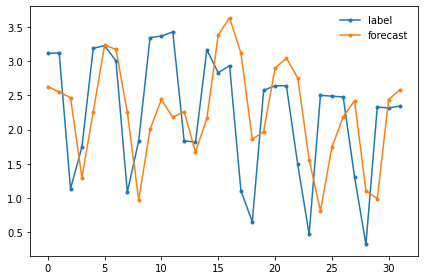

In [7]:
for x, y in valid_set.take(1):
    y_pred = model.predict(x)
    plt.plot(y, '.-', label='label')
    plt.plot(y_pred, '.-', label='forecast')
    plt.legend(frameon=False)
    plt.tight_layout()